# Analyse de commentaires YouTube

Projet Python de deuxième année à l'ENSAE Paris.

 Louisa Camadini, Antoine Lelong, Yseult Masson

# Introduction

Les commentaires postés sous les vidéos YouTube sont une source d'information, complémentaire avec les "likes", pour les créateurs de contenu. Ils permettent au vidéaste de déterminer si son travail a plu ou non à son audience. Cependant, les Youtubeurs n'ont pas nécessairement le temps de tous les lire. Il nous a donc semblé intéressant d'analyser ces commentaires informatiquement, plutôt que de les traiter un à un.

Pour ce projet, nous nous sommes penchés sur la chaîne YouTube DirtyBiology, qui fait de la vulgarisation scientifique. Notre choix a été motivé par le fait que les commentaires sous ces vidéos sont à la fois nombreux (car la chaîne est relativement connue), en phrases (étant donné l'audience cible) et sans trop de fautes d'ortographes. Cela nous a permis d'avoir des données exploitables pour l'analyse que nous voulions en faire.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
#!pip install -r requirements.txt

In [3]:
# Import des modules utiles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1 - Webscraping, création et nettoyage de la base de données

## 1.1 - Webscraping

Dans un premier temps, nous avons utilisé [l'API YouTube Data](https://developers.google.com/youtube/v3), qui nous permet de récupérer les 100 commentaires les plus "pertinents" d'une vidéo, sur jusqu'à 20 vidéos différentes, constituant une base de données de 2000 commentaires, ainsi que quelques données supplémentaires, comme le nombre de likes, le nom d'utilisateur...  
Le script`scraper.py` va chercher ces données et les stocke dans le fichier `comments.csv`.  
Les API Google fonctionnent avec des clés d'identification confidentielles, qui n'apparaissent par conséquent pas dans le dépot github. Pour faire fonctionner le script correctement, il faut créer un fichier s'apppelant `.env` et y placer la ligne suivante :  
`APIKEY="identifiant_de_la_clé"`  
Dans tous les cas, le fichier `comments.csv` que nous avons constitué est, lui, disponible dans le dépot.

In [4]:
#!python scraper.py

## 1.2 - Nettoyage de la base de données

Le script cleaning prépare les commentaires pour les autres parties, en retirant les majuscules, sauts de lignes... en créant une nouvelle variable `textClean`.

In [5]:
#!python cleaning.py

In [6]:
data = pd.read_csv("comments.csv")
data.head(3)

,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,publishedAt,updatedAt,commentLikeCount,viewCount,commentCount,videoLikeCount,videoTitle,videoDate,textClean
0,EfH0oscLFhk,Du coup peut on dire qu’on a encore plus de ch...,Du coup peut on dire qu’on a encore plus de ch...,Minx,https://yt3.ggpht.com/ytc/AKedOLQAMtKSrCPfkjfg...,http://www.youtube.com/channel/UCm1YdSnO2Y7vuw...,UCm1YdSnO2Y7vuwTr6yTKwAw,True,none,2022-01-01T17:22:33Z,2022-01-01T17:22:33Z,1023,388701,849,34914,La vie est-elle un (gros) coup de chance ? - D...,2022-01-01T17:18:55Z,du coup peut on dire qu’on a encore plus de ch...
1,EfH0oscLFhk,"J&#39;ai eu ton livre à Noël, il est incroyabl...","J'ai eu ton livre à Noël, il est incroyable, m...",Maxime ',https://yt3.ggpht.com/ytc/AKedOLRol_dSsQ7cG04a...,http://www.youtube.com/channel/UCeoRNNIN1PVzIh...,UCeoRNNIN1PVzIhhoxhSDv6g,True,none,2022-01-01T17:24:31Z,2022-01-01T17:24:31Z,364,388701,849,34914,La vie est-elle un (gros) coup de chance ? - D...,2022-01-01T17:18:55Z,"j'ai eu ton livre à noël, il est incroyable, m..."
2,EfH0oscLFhk,"Ton livre a Noël, meilleur cadeau ! Merci 😊","Ton livre a Noël, meilleur cadeau ! Merci 😊",Light,https://yt3.ggpht.com/8Z5CHat3_hAP1fIOHdEasFFD...,http://www.youtube.com/channel/UCdg5gH0YGsCA3T...,UCdg5gH0YGsCA3ThvnFE4jUw,True,none,2022-01-03T12:12:39Z,2022-01-03T12:12:39Z,9,388701,849,34914,La vie est-elle un (gros) coup de chance ? - D...,2022-01-01T17:18:55Z,"ton livre a noël, meilleur cadeau ! merci 😊"


# 2 - Analyse des commentaires
## 2.1 - Analyse exploratoire quantitative

Par simplicité, on remplace les identifiants des vidéos par des numéros dans l'ordre de publication (1 pour la plus ancienne, 20 pour la dernière).

In [7]:
dico = {data.videoId.unique()[i] : 20- i for i in range(len(data.videoId.unique()))}
data['videoId'] = data['videoId'].replace(to_replace=dico)
data.sample(4)

,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,publishedAt,updatedAt,commentLikeCount,viewCount,commentCount,videoLikeCount,videoTitle,videoDate,textClean
341,17,Mais la qualitéeeeee du montage ! Ta vidéo est...,Mais la qualitéeeeee du montage ! Ta vidéo est...,L' instrumentiste,https://yt3.ggpht.com/ytc/AKedOLRvaLBsBi6u6PCo...,http://www.youtube.com/channel/UCEymyPG_18CN4n...,UCEymyPG_18CN4nC2Tg3XN2Q,True,none,2021-10-10T23:53:42Z,2021-10-10T23:53:42Z,0,586535,1267,49600,La méthode pour ressusciter des espèces dispar...,2021-10-09T15:41:15Z,mais la qualitéeeeee du montage ! ta vidéo est...
1408,6,Merci à toi Léo !<br>Une vidéo passionnante et...,Merci à toi Léo !\nUne vidéo passionnante et q...,Gaëlle Poupin,https://yt3.ggpht.com/ytc/AKedOLRxam8Lbllvj9hR...,http://www.youtube.com/channel/UCnThSQ6N-BRCZF...,UCnThSQ6N-BRCZF6VVe2HAMA,True,none,2020-11-28T19:11:11Z,2020-11-28T19:11:11Z,0,705307,3259,64616,Ce virus nous manipule ? - DBY #73,2020-11-25T11:07:28Z,merci à toi léo !\nune vidéo passionnante et q...
1962,1,"C’est cool, t’arrives a rester dans la tendanc...","C’est cool, t’arrives a rester dans la tendanc...",Quentin Carron,https://yt3.ggpht.com/ytc/AKedOLQSa8QR1E8xj-bZ...,http://www.youtube.com/channel/UCz39WWTc3VEvDa...,UCz39WWTc3VEvDaOzxB8fe6g,True,none,2020-04-25T06:40:17Z,2020-04-25T06:40:17Z,0,1409977,3674,95877,Les futures épidémies que nous vivrons - DBY #68,2020-04-23T16:08:22Z,"c’est cool, t’arrives a rester dans la tendanc..."
848,12,Un souffle d&#39;intelligence qui fait toujour...,Un souffle d'intelligence qui fait toujours pl...,Patricia L,https://yt3.ggpht.com/ytc/AKedOLSq2-CtPI4TI9iM...,http://www.youtube.com/channel/UCsxFBzKHRY1gyG...,UCsxFBzKHRY1gyGf6A4VJnIg,True,none,2021-06-09T08:01:23Z,2021-06-09T08:01:23Z,0,739809,3969,86993,Comment une agence russe a essayé de m&#39;uti...,2021-06-07T16:10:33Z,un souffle d'intelligence qui fait toujours pl...


Certaines données caractérisent la vidéo et non le commentaire, nous les récupèrons dans une autre DataFrame. Elles sont égales sur une vidéo, donc égales à leur max sur ces groupes :

In [8]:
info_video = data.groupby('videoId')[['viewCount', 'commentCount', 'videoLikeCount','videoDate']].max()

Nous calculons la proportion de viewers qui likent et commentent :

In [9]:
info_video['ratioLike'] = info_video['videoLikeCount'] / info_video['viewCount']
info_video['ratioComment'] = info_video['commentCount'] / info_video['viewCount']
info_video.tail(3)

,viewCount,commentCount,videoLikeCount,videoDate,ratioLike,ratioComment
videoId,,,,,,
18,793269,2551,55911,2021-11-01T13:40:00Z,0.070482,0.003216
19,418526,795,37787,2021-12-12T13:00:37Z,0.090286,0.001900
20,388701,849,34914,2022-01-01T17:18:55Z,0.089822,0.002184


Nous créons une variable correspondant au nombre de mois entre la publication de la vidéo et celle de la dernière vidéo de la base de données :

In [10]:
nbr_mois = lambda date: 25 - (int(date[5:7]) + 12 * int(date[3]))
info_video['Ancienneté'] = info_video.videoDate.apply(nbr_mois)
info_video.head(3)

,viewCount,commentCount,videoLikeCount,videoDate,ratioLike,ratioComment,Ancienneté
videoId,,,,,,,
1,1409977,3674,95877,2020-04-23T16:08:22Z,0.067999,0.002606,21
2,815210,3970,75556,2020-06-27T17:02:26Z,0.092683,0.004870,19
3,1229621,8193,100902,2020-07-23T10:58:44Z,0.082059,0.006663,18


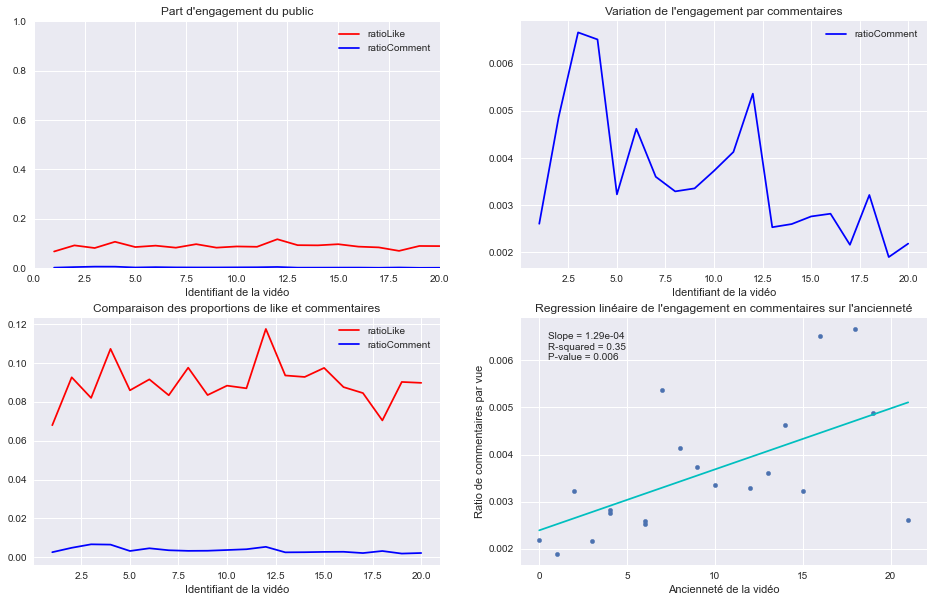

In [11]:
from scipy.stats import linregress

plt.style.use('seaborn')

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

info_video.plot(y='ratioLike', ax=axs[0][0], color='r')
info_video.plot(y='ratioComment', ax=axs[0][0], color='b')
axs[0][0].axis([0, 20, 0, 1])
axs[0][0].set_xlabel("Identifiant de la vidéo")
axs[0][0].set_title("Part d'engagement du public")

info_video.plot(y='ratioLike', ax=axs[1][0], color='r')
info_video.plot(y='ratioComment', ax=axs[1][0], color='b')
axs[1][0].set_xlabel("Identifiant de la vidéo")
axs[1][0].set_title("Comparaison des proportions de like et commentaires")

info_video.plot(y='ratioComment', ax=axs[0][1], color='b')
axs[0][1].set_xlabel("Identifiant de la vidéo")
axs[0][1].set_title("Variation de l'engagement par commentaires")


slope, intercept, r_value, p_value, std_err = linregress(x=info_video.Ancienneté, y=info_video.ratioComment)

info_video.plot.scatter(x='Ancienneté', y='ratioComment', ax=axs[1][1])
axs[1][1].plot(info_video.Ancienneté, slope * info_video.Ancienneté + intercept, color='c')
axs[1][1].set_title("Regression linéaire de l'engagement en commentaires sur l'ancienneté")
axs[1][1].set_xlabel('Ancienneté de la vidéo')
axs[1][1].set_ylabel('Ratio de commentaires par vue')
plt.text(x=0.5, y=0.006, s=f"Slope = {slope:.2e}\nR-squared = {r_value ** 2:.2f} \nP-value = {p_value:.3f}")


plt.show()


Comme on peut le voir, la part de viewers qui likent et commentent reste stable autour de 9% et 0.4% respectivement, soit une minorité de la totalité des viewers.  
On remarque une tendance d'augmentation de la proportion de viewers qui commentent avec l'ancienneté de la vidéo, ce qui suggère que les personnes qui regardent une vidéo tard par rapport à sa sortie ont plus tendance à la commenter. L'interprétation de la régression linéaire donne que pour chaque mois qui passe, cette proportion augmente en moyenne de 0.001 (pour rappel, elle varie aux alentours de 0.004 sur les observations). La P-valeur à 0.006 montre que le coefficient de la courbe est significatif au seuil 1%. 

## 2.2 - Thèmes majoritairement abordés dans les commentaires

Imports nécessaires pour cette partie

In [12]:
import nltk
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [13]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### A - Tokenisation

Nous allons nous intéresser à la colonne `textClean` qui a été nettoyée au préalable. Chaque ligne du dataframe représente un commentaire. L'ensemble de ces lignes, c'est-à-dire tous les commentaires, correspondent donc à notre texte d'étude. Il s'agit tout d'abord de décomposer le texte en unités lexicales, afin de pouvoir analyser les impressions laissées en commentaire.

In [14]:
content = " ".join(data['textClean'])

words = nltk.word_tokenize(content, language='french')
#words[200:250]

La texte a bien été décomposé en 'tokens', mais ce ne sont pas tous des mots : certains peuvent être des signes de ponctuation, des smileys... 
La méthode `isalpha()` renvoie "True" si tous les caractères de la chaîne sont des alphabets, on l'utilise pour ne garder que les 'tokens' qui sont des mots.

In [15]:
words = [word for word in words if word.isalpha()]
#words[200:250]

Maintenant, certains mots comme les déterminants ou pronoms, sont répétitifs et inutiles à l'analyse du texte. Nous supprimons donc ce qu'on appelle les 'stopwords' :

In [16]:
stop_words = set(stopwords.words('french'))

words = [w for w in words if not w in stop_words]
print(words[200:250])

['toujours', 'plus', 'qualitatives', 'pédagogique', 'toujours', 'superbes', 'vidéo', 'passionnant', 'mec', 'montage', 'malade', 'rend', 'tout', 'léger', 'digeste', 'bien', 'joué', 'incroyable', 'retrouver', 'telles', 'notions', 'physique', 'coût', 'énergie', 'création', 'surface', 'vidéos', 'bisous', 'livre', 'a', 'noël', 'meilleur', 'cadeau', 'merci', 'old', 'boy', 'manga', 'a', 'base', 'assez', 'incroyable', 'a', 'lire', 'bien', 'aimé', 'montage', 'droite', 'gauche', 'imagine', 'chance']


### B - Création de WordClouds

Ils permettent de synthétiser les mots et expressions qui reviennent le plus couramment dans les commentaires.
Les images produites pour cette partie sont disponibles dans l'onglet [graphes](https://github.com/taucmar/projet-python-2a/tree/main/graphs) de notre dépôt GitHub.

In [17]:
text = " ".join(words)

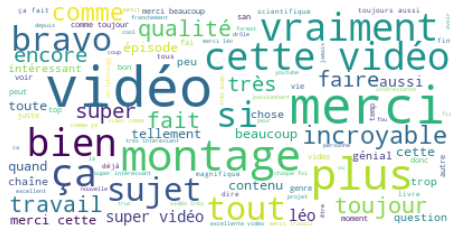

In [18]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Nous avons généré ici un premier nuage de points classique, composé de 100 mots qui semblent positifs dès le premier coup d'œil :  travail, merci, incroyable , bravo, intéressant, qualité...  
Nous customisons ce nuage de mots en l'intégrant au logo YouTube

In [19]:
mask = np.array(Image.open("mask.png"))

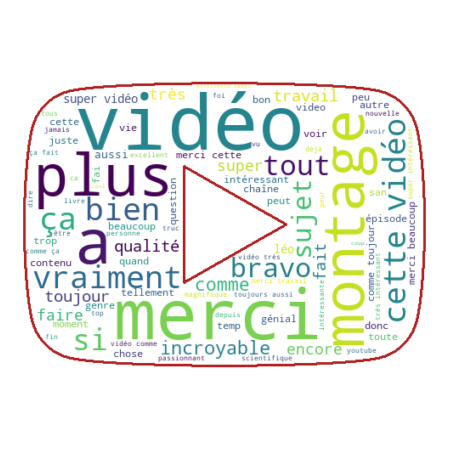

In [20]:
wc = WordCloud(background_color="white", max_words=90, mask=mask,
               stopwords=stop_words, contour_width=3, contour_color='firebrick')

wc.generate(text)

wc.to_file("./graphs/logo_youtube.png")

plt.figure(figsize=[10,8])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Mieux encore, nous pouvons utiliser le logo de DirtyBiology, en retravaillant des [images](https://www.pinterest.fr/pin/148689225175699166/) trouvées sur Internet. L'image qui suit a été produite de la même manière.

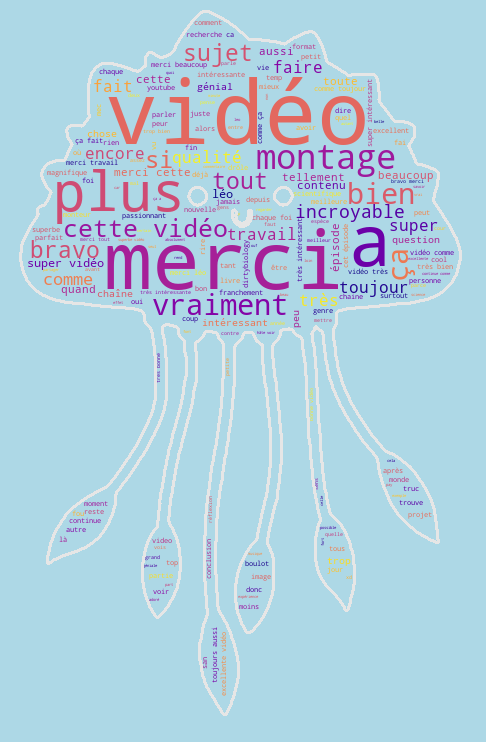

In [21]:
from IPython.display import Image
Image("./graphs/logo_dirty_bio.png")

## 2.3 - Polarisation des commentaires

### A - Calcul de polarités

Le module TextBlob est un module python de NLP utilisé pour l'analyse de sentiments et qui permet, entre autres, de calculer la polarité d'un texte. Celle-ci est un nombre entre -1 et 1, qui détermine le degré de satisfaction ou d'insatisfaction qui se dégage du texte. Plus la polaritée est proche de 1, plus le texte dégage un sentiment positif, et vice-versa.

Nous avons calculé la polarité de chaque commentaire de deux façons. Les fonctions permettant de faire ces calculs se trouvent dans le fichier `polaritation_utiles.py`. Nous avons d'une part appliqué directement la fonction du module TextBlob qui nous intéresse au commentaire. D'autre part, nous avons découpé chaque commentaire en phrases, avant d'appliquer à chacune de celles-ci la fonction qui renvoie leur polarisation, puis d'en faire la moyenne sur toutes les phrases du commentaire.

In [22]:
import polarisation_utiles as pu

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Nous avons ensuite ajouté 2 nouvelles colonnes à la base de données:

   - Polarity : polarité de chaque commentaire, calculée sur le commentaire entier directement
    
   - sentencesPolarity : polarité de chaque commentaire, calculée en prenant la moyenne des polarités sur chaque phrase que comporte le commentaire.

In [23]:
data["Polarity"] = data.loc[:, ['textClean']].apply(pu.blober)
data["sentencesPolarity"] = data.loc[:, ['textClean']].apply(pu.polarisation)

Pour la clarté des graphiques nous avons créé une colonne correspondant aux numéros des vidéos indiqués dans les titres.

In [24]:
data['DBY'] = data.loc[:, ['videoTitle']].apply(np.vectorize(lambda string : string[-7:]))

### B - Analyse des polarités

**Analyse d'une vidéo**

Dans un premier temps, nous nous intéressons à la répartition des polarités pour une vidéo, ici la vidéo *Comment ces champis nous ont façonnés - DBY #76*.

In [25]:
DBY76 = data.loc[data['DBY'] == "DBY #76", ['Polarity', 'sentencesPolarity']]
DBY76.describe()

,Polarity,sentencesPolarity
count,100.000000,100.000000
mean,0.358376,0.308844
std,0.291595,0.259852
min,-0.200000,-0.106000
25%,0.145833,0.121979
50%,0.343125,0.252500
75%,0.499766,0.450833
max,1.000000,1.000000


On voit que pour les deux types de polarité, il y a très peu de valeurs négatives. Cela signifie que les commentaires de cette vidéo sont pour la plupart perçus comme positifs.
Les écarts type sont de 0.29 et 0.26, ce qui est assez élevé pour des valeurs de polarités allant entre -0.2 (-0.1 pour "sentencesPolarity") et 1. Ainsi, les commentaires de cette vidéo dégagent plusieurs degrés de satisfaction, allant de neutre à très satisfait. La moitié d'entre eux sont relativement satisfaits, et ont une polarité se trouvant entre 0.15 et 0.50 (0.12 et 0.45 pour sentencesPolarity).

Cela se perçoit bien sur les histogrammes ci-dessous:

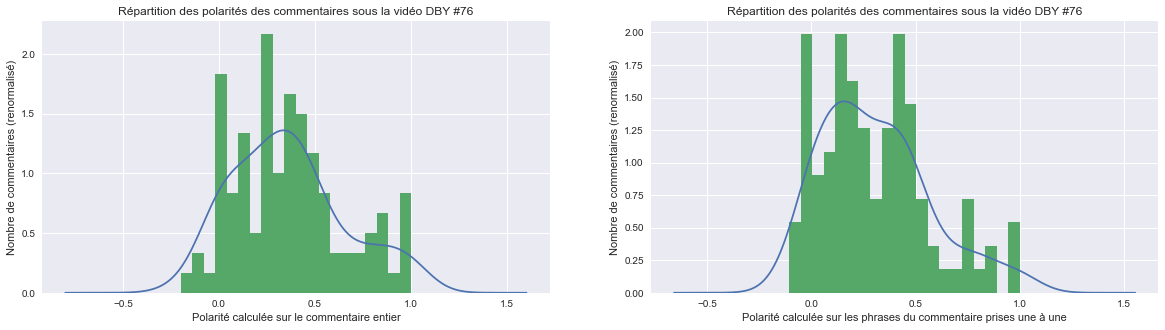

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

DBY76['Polarity'].plot.density(ax = axs[0])
DBY76['Polarity'].plot.hist(bins=20, density=True, ax = axs[0])

axs[0].set_xlabel("Polarité calculée sur le commentaire entier")
axs[0].set_ylabel("Nombre de commentaires (renormalisé)")
axs[0].set_title("Répartition des polarités des commentaires sous la vidéo DBY #76")

DBY76['sentencesPolarity'].plot.density(ax=axs[1])
DBY76['sentencesPolarity'].plot.hist(bins=20, density=True, ax=axs[1])

axs[1].set_xlabel("Polarité calculée sur les phrases du commentaire prises une à une")
axs[1].set_ylabel("Nombre de commentaires (renormalisé)")
axs[1].set_title("Répartition des polarités des commentaires sous la vidéo DBY #76")

plt.show()


**Comparaison des vidéos entre elles**

Nous avons ensuite fait la moyenne des polarités sur les 100 commentaires de chaque vidéo, ce qui nous permet de comparer les vidéos entre elles.

In [27]:
datapol = data.groupby(['DBY']).mean().sort_values('Polarity', ascending = False)
datapol.loc[:, ['videoLikeCount', 'Polarity', 'sentencesPolarity']]

,videoLikeCount,Polarity,sentencesPolarity
DBY,,,
DBY #72,87990.0,0.391309,0.378558
DBY #81,40049.0,0.389876,0.322359
DBY #74,50146.0,0.374054,0.324198
DBY #80,42480.0,0.363191,0.331241
DBY #76,47151.0,0.358376,0.308844
DBY#84,49600.0,0.353083,0.297797
DBY #87,34914.0,0.346008,0.299026
DBY #77,62564.0,0.339487,0.299937
DBY #82,46060.0,0.334684,0.296303


Nous avons cherché à savoir si les résultats de polarisation restaient cohérents entre les deux méthodes utilisées.

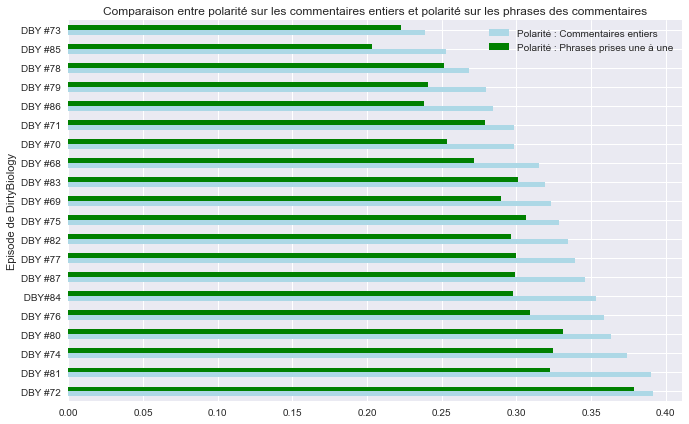

In [28]:
datapol.loc[:,['Polarity', 'sentencesPolarity']].plot(kind='barh', figsize=(11, 7), color=['lightblue', 'green'], title='Comparaison entre polarité sur les commentaires entiers et polarité sur les phrases des commentaires', xlabel='Episode de DirtyBiology')
plt.legend(labels=['Polarité : Commentaires entiers', 'Polarité : Phrases prises une à une'])
plt.show()

L'ordre des vidéos change un peu selon la définition que l'on utilise pour la polarité, mais les deux définitions semblent tout de même corrélées (globalement, la polarité prise sur chaque phrase augmente avec celle prise sur le commentaire entier).

Dans la suite, nous garde la polarité sur le commentaire entier.

**Relation entre le nombre de likes d'un commentaire et sa polarité**

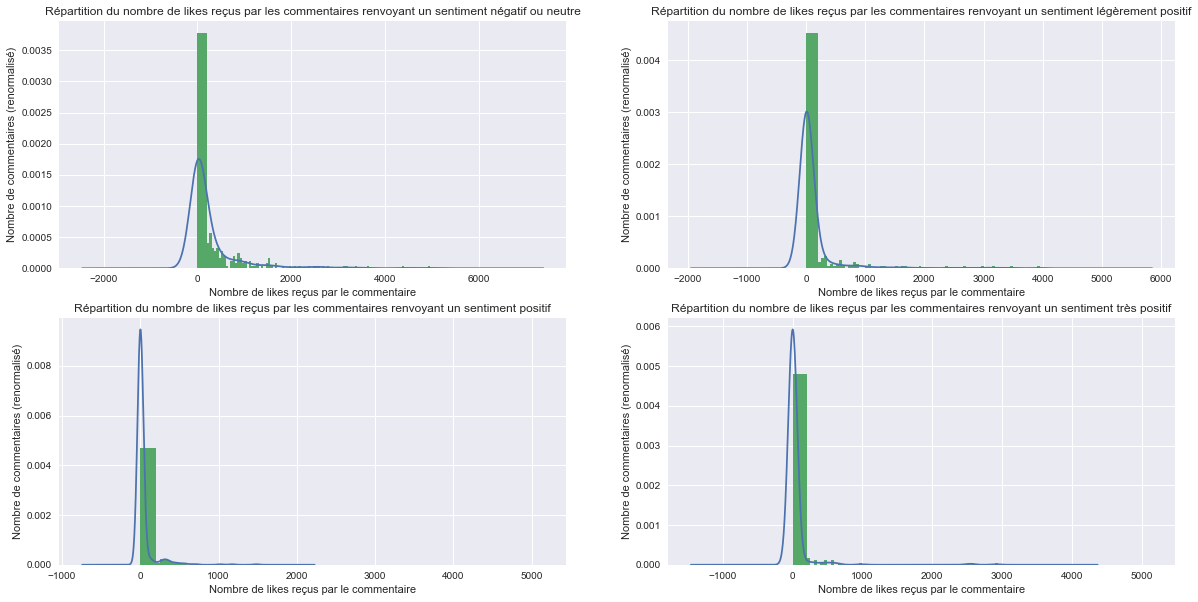

In [29]:
data2 = data.sort_values("Polarity").set_index("Polarity")["commentLikeCount"]

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for i, ax in enumerate(np.array(axs).flatten()):
    plot_data = data2.iloc[500 * i:500 * (i + 1)]
    plot_data.plot.density(ax=ax)
    plot_data.plot.hist(bins=[0] + [200 + 50 * i for i in range(100)], density=True, ax=ax)
    ax.set_xlabel("Nombre de likes reçus par le commentaire")
    ax.set_ylabel("Nombre de commentaires (renormalisé)")
    ax.set_title("Répartition du nombre de likes reçus par les commentaires renvoyant un sentiment " + ["négatif ou neutre", "légèrement positif", "positif", "très positif"][i])

Sur chacun des graphiques, la première barre représente les commentaires ayant reçu moins de 200 likes. En effet, il y a énormément de commentaires qui reçoivent 0 likes, et la barre associée dans l'histogramme écrase les autres si on ne réunit pas plus de valeurs autour de 0.  
Il semble que les commentaires les moins positifs (ce qui ont la polarité la plus faible) sont ceux qui ont le plus de chance d'avoir du succès. Cela pourrait être dû au fait que les commentaires émettant un avis, qui sont ceux qui reçoivent le plus de likes, sont plutôt neutres, contrairement à ceux qui indiquent que la vidéo a plu, qui dégagent un sentiment positif, mais ne suscite pas particulièrement d'être likés par d'autres viewers. L'analyse en wordcloud suggère que ce dernier genre de commentaires est très présent dans notre corpus.

**Pertinence de la polarité**

La polarité devrait être un témoin du succès qu'a eu une vidéo. Nous cherchons à présent à la comparer à un autre marqueur de ce succès, à savoir le ratio de likes qu'a reçu une vidéo par rapport à son nombre de vues.

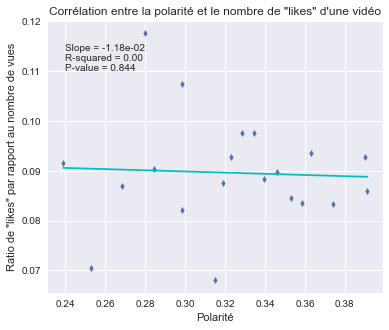

In [30]:
datapol['likeRatio'] = datapol['videoLikeCount'] / datapol['viewCount']
datapol.plot(kind='scatter', 
             x='Polarity', 
             y='likeRatio', 
             figsize=(6, 5), 
             marker='d', 
             xlabel='Polarité', 
             ylabel='Ratio de \"likes\" par rapport au nombre de vues', 
             title='Corrélation entre la polarité et le nombre de \"likes\" d\'une vidéo')

slope, intercept, r_value, p_value, std_err = linregress(x=datapol.Polarity, y=datapol.likeRatio)

plt.plot(datapol.Polarity, slope * datapol.Polarity + intercept, color='c')
plt.text(x=0.24, y=0.11, s=f"Slope = {slope:.2e}\nR-squared = {r_value ** 2:.2f} \nP-value = {p_value:.3f}")
plt.show()

Il semble ne pas y avoir de corrélation entre ces deux marqueurs, ce que confirme la regression linéaire précédente : le coefficient de la droite de regression a une P-valeur de 0.84, donc il n'est pas significatif.  
Cela peut être dû au fait que la polarisation ne soit pas très précise, ou que les personnes qui commentent les vidéos n'aient pas le même profil que ceux qui se contentent de liker.

## 2.4 - Analyse en composantes principales

Dans cette partie, nous utilisons la bibliothèque [Sentence Transformer](https://github.com/UKPLab/sentence-transformers) pour transformer les phrases en vecteurs réels. Cela nous permet ensuite de faire une ACP, pour visualiser les différences entre les commentaires, et étudier les plus extrêmes, puisque l'ACP conserve un maximum de variance.

In [31]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sentence_transformers import SentenceTransformer

### A - Préparation de l'encoding
1. Nous récupèrons les commentaires
2. Nous isolons le texte du reste de la base de données
3. Dans la liste `font`, nous faisons correspondre à chaque indice de commentaire le numéro de la vidéo associée (pour faire des catégories dans l'ACP)

In [32]:
st = SentenceTransformer("xlm-r-bert-base-nli-stsb-mean-tokens")

comments = data[['textClean', 'DBY']]

text = comments["textClean"].values.tolist()

dico_font_video = {}

for i, videoid in enumerate(comments.DBY.unique()):
    dico_font_video[videoid] = i

font = [dico_font_video[videoid] + 1 for videoid in comments.DBY]

### B -  Encoding et ACP

Nous pouvons ensuite encoder le texte, ce qui les transforme en vecteurs de $\mathbb{R}^{768}$, que nous projetons après dans $\mathbb{R}^{2}$ :

In [33]:
embs = st.encode(text)
pca = PCA(2).fit_transform(embs)

### C - Clustering
Pour une première visualisation, nous réunissons les commentaires par clusters (dans  $\mathbb{R}^{768}$) en utilisant la méthode des [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), et nous utilisons ces catégories lorsque nous affichons les points de l'ACP dans $\mathbb{R}^{2}$. Nous récupèrons aussi les commentaires les plus proches des centroïdes afin d'avoir un commentaire "représentant" pour chaque cluster.

In [34]:
kmeans = KMeans(5, n_init=20, max_iter=2000).fit(embs)

center_indices = [
    int(np.argmin([np.sum((x-centroid)**2) for x in embs]))
    for centroid in kmeans.cluster_centers_]

commentaires_representants = [comments.textClean[i] for i in center_indices]
representants = ''
for i, comment in enumerate(commentaires_representants):
    representants += f'{i}:{comment} \n'

En préparation de l'affichage de cette partie et de la suivante, Nous stockons toutes les informations constituées jusque là dans une nouvelle base de données.

In [35]:
df_plot = pd.DataFrame(np.array([pca[:, 0], pca[:, 1], comments.DBY, kmeans.labels_]).transpose(),
                    columns=['x', 'y', 'video#', 'label'])
df_plot = df_plot.sample(frac=1)

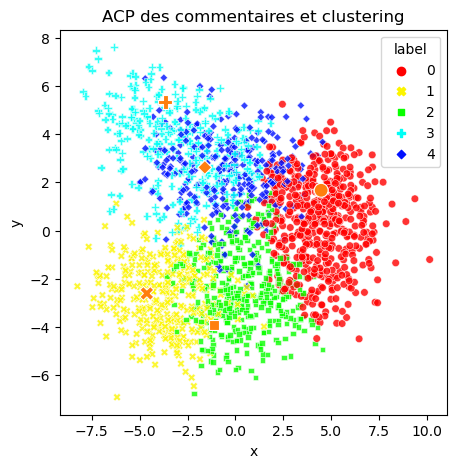

0:enfaite c'est moi ou ça peut servir de cours/tuto pour toujours gagné sur plague inc 😂👍🏽 sinon tres instructifs et intéressant. 
1:la qualité de cette vidéo est impressionnante. merci de faire découvrir la démarche scientifique 
2:mais la qualitéeeeee du montage ! ta vidéo est incroyable et passionnante comme toujours ! tu gère la fougère ^^ 
3:un régal, comme d'hab! merci pour ce très beau travail 
4:le montage est toujours aussi bon c’est ouf 🤌🏼 



In [36]:
plt.style.use('default')
plt.figure(figsize=(5, 5))
sns.scatterplot(data=df_plot,
                x='x',
                y='y',
                hue='label',
                style='label',
                s=30,
                hue_norm=(0, 6),
                alpha=.8,
                palette='hsv',
                legend='full')

# Mise en avant des centroides
sns.scatterplot(x=[pca[i, 0] for i in center_indices], 
                y=[pca[i, 1] for i in center_indices],
                style=[i for i in range(len(center_indices))],
                s=100,
                legend=False)
plt.title("ACP des commentaires et clustering")
plt.show()
print(representants) #la liste des représentants a été faite avant le mélange de la dataframe

Les commentaires centroides sont tous positifs, ce qui suggère que ce qui éloigne les plus les différents clusters les uns des autres ne réside pas dans la positivité ou négativité du commentaire .

### D - Affichage par vidéo

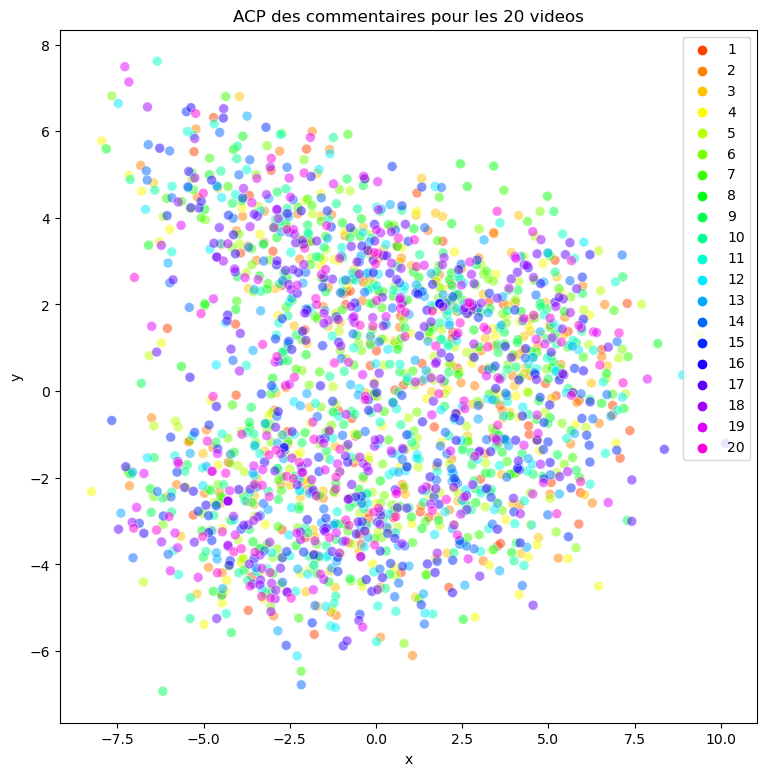

In [37]:
plt.figure(figsize=(9, 9))
sns.scatterplot(data=df_plot,
                x='x',
                y='y',
                hue=font,
                hue_norm=(0, 23),
                s=50,
                palette='hsv',
                alpha=.5,
                legend='full')
plt.title("ACP des commentaires pour les 20 videos")

plt.show()

Les commentaires de chaque vidéo ne semblent pas former de cluster particuliers dans l'ACP, nous pouvons donc en déduire qu'aucune vidéo n'a suggéré de réaction particulièrement différente des autres, ou bien si des clusters sont cachés dans les dimensions perdues de la projections, c'est qu'ils ont des variances plus faibles que les différences observées dans l'ACP, car le but de l'ACP est de trouver le plan qui conserve au maximum la variance du nuage de points.  
Pour vérfier encore ces similarités, nous affichons simultannément l'ACP pour chaque nuage de point plutôt que de les superposer.  
Nous entourons également les nuages de points par l'enveloppe convexe du nuage total afin d'avoir un repère commun :

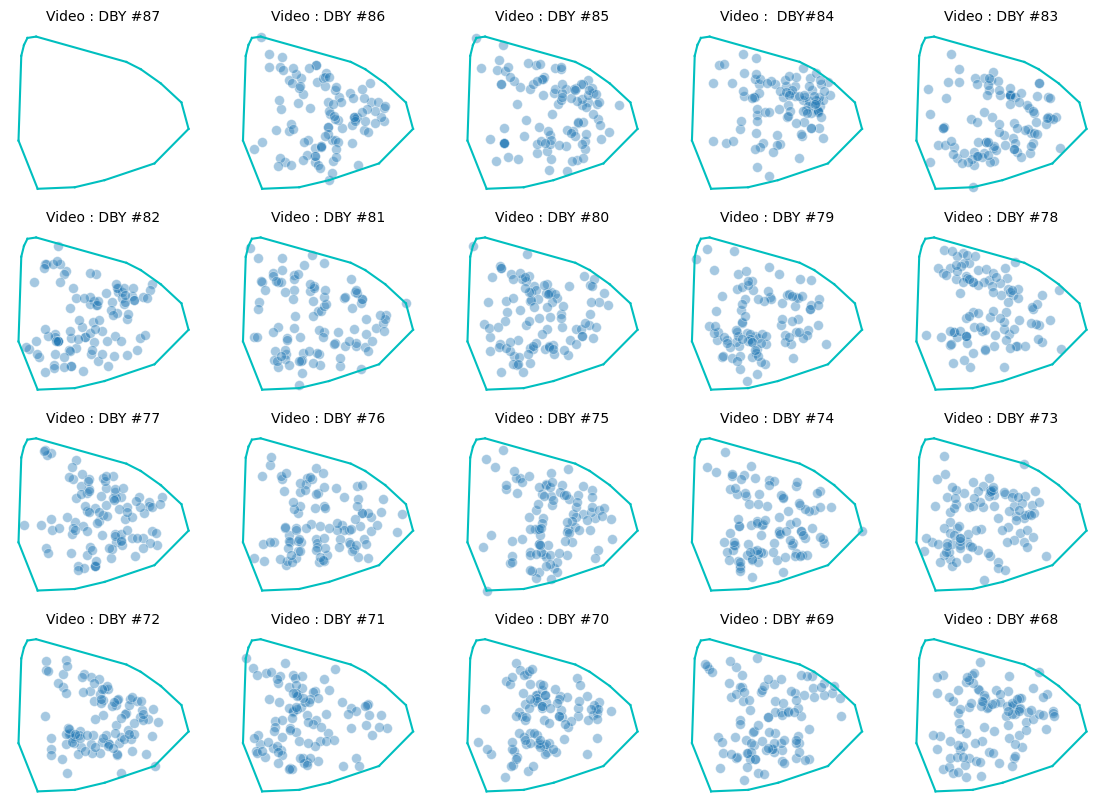

In [38]:
from scipy.spatial import ConvexHull

hull = ConvexHull(pca)

fig, axs = plt.subplots(4, 5, figsize=(14, 10))
for i, ax in enumerate(np.array(axs).flatten()):
    sns.scatterplot(x=[pca[j, 0] for j in range(len(font)) if font[j] == i],
                    y=[pca[j, 1] for j in range(len(font)) if font[j] == i],
                    s=50,
                    ax=ax,
                    alpha=0.4)
    for simplex in hull.simplices:
            ax.plot(pca[simplex, 0], pca[simplex, 1], 'c')
    ax.set_title(f'Video : {comments.DBY[i*100]}', fontsize=10)
    ax.axis('off')
plt.show()

Les nuages de points semblent se déplacer de gacuche à droite principalement, mais les variations ne sont pas énormes. Concrètement, les vidéos suscitent des réations similaires.  
### E - À la frontière de l'ACP
Les axes de l'ACP ne sont pas porteurs d'un sens clairement identifiable étant donnée la nature de la transformation des commentaires en vecteurs. Nous pouvons néanmoins essayer de leur donner un sens en regardant les valeurs extrêmes de l'ACP et determiner ce qui éloigne les commentaire les plus éloignés d'un point de vue sémantique. Nous allons voir par la suite que ce n'est pas forcément une tache facile.

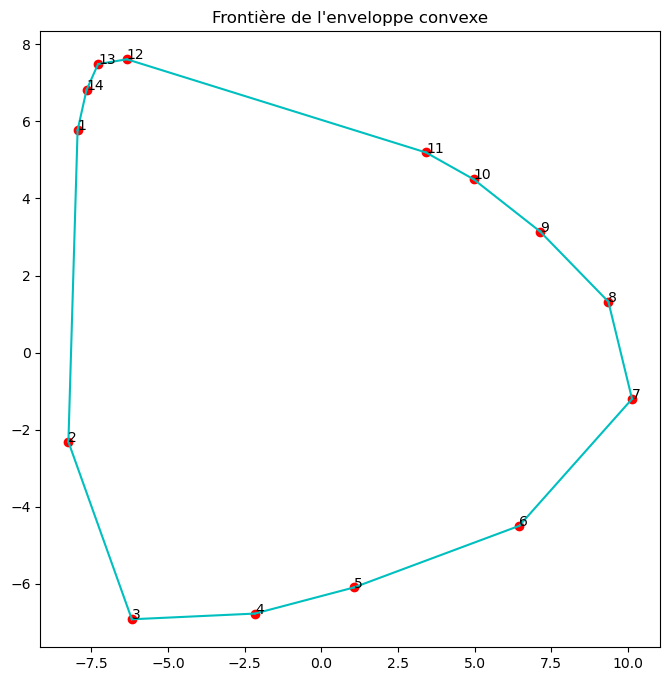

1 : c'était passionnant, merci pour ton travail !
 2 : merci pour cette vidéo très enrichissante!
 3 : tes vidéos sont vraiment incroyable !
 4 : je tenais à dire que tu as probablement le meilleur monteur vidéo du monde, tes vidéos me font rire à chaque fois, et apprendre beaucoup de choses intéressantes, un grand bravo !
 5 : je regarde cette chaîne sérieusement depuis des années et je pense ne pas me tromper en disant que cette vidéo est la plus ''mindblowing'' de toutes
 6 : mais bordel pourquoi je regarde systématiquement tes vidéos en mangeant je suis si idiot . _.'
 7 : un jour je préparais un quiz pour des enfants, et j'ai hésité à intégrer les virus dans les "formes de vie". j'avais été frappé par ce désaccord des biologistes. peux-tu nous en parler ou en as-tu déjà parlé ? 🙂
 8 : birdy biology au beau milieu de son trajet: "merde! j'ai pensé à éteindre le four ou pas?"
 9 : dirtybiology : le rose n'existe pas 

moi : regarde toulouse s'enfoncer dans un vortex spatio-temporel


In [39]:
plt.figure(figsize=(8,8))
for simplex in hull.simplices:
    plt.plot(pca[simplex, 0], pca[simplex, 1], 'c')
bound = np.array([pca[i] for i in hull.vertices])
plt.scatter(x=bound[:, 0], y=bound[:, 1], color='r')
for name, vect in zip(range(len(bound)), bound):
    plt.annotate(name + 1, vect)

plt.title("Frontière de l'enveloppe convexe")
plt.show()
print(*[f'{i+1} : ' + text[ind]+'\n' for i, ind in enumerate(hull.vertices)])

On remarque tout de suite que les commentaires de la région en haut à gauche (1, 2, 12, 13 et 14) partagent tous le même mot : "merci" et saluent la qualité et l'intérêt qu'ils ont pour la vidéo ('passionnant', 'enrichissant', 'intéressant', 'beau travail', 'travail de qualité'). Les commentaires du bas sont également élogieux. Tandis que les commentaires de la région opposée intègrent du langage fleuri (6: 'bordel', 8: 'merde') et sont moins élogieux, le commentaire le plus à droite semblant venir d'un professeur voulant se renseigner ne fait part d'aucun éloge.  
On peut donc supposer que plus on se déplace vers la partie gauche de l'espace, plus les commentaires sont élogieux, et les remerciements nombreux.

Nous allons essayer de vérifier cette interprétation.
Nous isolons d'abord les commentaires comprenant des remerciements :

In [40]:
def find_remerciement(string):
    return ('merci' in string) or ('thank' in string) or ('thx' in string)
df_plot = df_plot.sort_index() # On remet les commentaire dans l'ordre de leurs indices
remerciements =  df_plot.iloc[[i for i in range(len(data)) if find_remerciement(text[i])]]

Nous vérifions l'espace qu'ils occupent dans l'ACP :

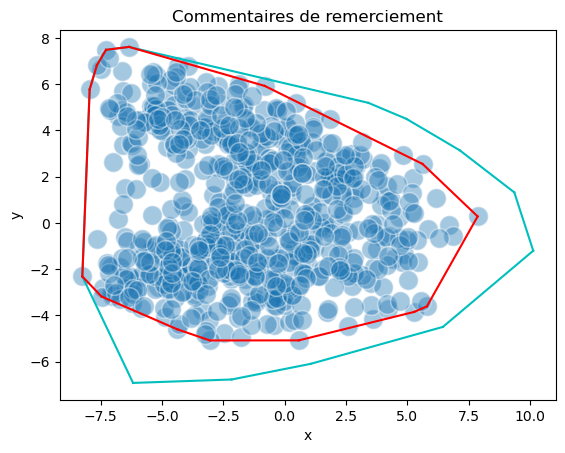

In [41]:
pca_remerciements = np.array(remerciements[['x','y']])
hull_remerciements = ConvexHull(pca_remerciements)

sns.scatterplot(data=remerciements,
                x='x',
                y='y',
                s=200,
                alpha=.4,
                legend='full')
for simplex in hull.simplices:
    plt.plot(pca[simplex, 0], pca[simplex, 1], 'c')
for simplex in hull_remerciements.simplices:
    plt.plot(pca_remerciements[simplex, 0], pca_remerciements[simplex, 1], 'r')
plt.title("Commentaires de remerciement")
plt.show()

Finalement, les remerciements occupent quasiment tout l'espace de commentaires, donc l'interprétation précédente ne tient pas, mais ce résultat recoupe avec la partie 2.2, où nous avions observé que 'merci' faisait partie des mots les plus présents du corpus.

# Conclusion

Il y a beaucoup de manières d'analyser informatiquement les données que YouTube met à disposition des vidéastes. Nous en avons étudié et présenté quelques unes dans ce projet.  
Nous avons commencé par analyser les données propres aux vidéos et à l'engagement qu'elles suscitent, à travers le nombre de likes et de commentaires qu'elles reçoivent. Ensuite, nous nous sommes penchés sur le contenu des commentaires. Nous avons étudié les mots qui revenaient le plus souvent, afin de dégager les thèmes majoritairement abordés par les viewers donnant leur opinion à propos de la vidéo. Ensuite, nous avons calculé et analysé la polarité des commentaires, un score entre -1 et 1 qui exprime le sentiment que dégage un commentaire. Enfin, nous avons étudié les différences entre les commentaires à l'aide d'une Analyse en Composantes Principales.  
Toutes ces analyses nous ont mené à la conclusion que les commentaires sous les vidéos de DirtyBiology sont en grande majorité positifs, parfois neutres. Parmis leurs nombreuses similarités, la communauté du YouTubeur semble exprimer une vive reconnaissance pour ses vidéos, et une appréciation particulière de la qualité de son travail, notamment l'attention portée au montage.